In [1]:
from keras.layers import Input, Dense
from keras.models import Model, load_model
from keras import backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from keras.callbacks import *
from keras import regularizers
from keras import optimizers
# sklearn
from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, auc, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler

# other
import time

Using TensorFlow backend.


In [2]:
# load training dataset
data_path = "./data/"
df_train_orig = pd.read_csv(data_path + "dataset03.csv", parse_dates = ['DATETIME'], dayfirst=True)

In [3]:
# get dates and columns with sensor readings
dates_train = df_train_orig['DATETIME']
sensor_cols = [col for col in df_train_orig.columns if col not in ['DATETIME','ATT_FLAG']]

# scale sensor data
scaler = MinMaxScaler()
X = pd.DataFrame(index = df_train_orig.index, columns = sensor_cols, data = scaler.fit_transform(df_train_orig[sensor_cols]))

# split into training and validation
X1, X2, _, _  = train_test_split(X, X, test_size=0.33, random_state=42)
#X:8761,X1:5869,X2:2892

In [4]:
# Load dataset with attacks
df_test_01 = pd.read_csv(data_path + "dataset04.csv", parse_dates = ['DATETIME'], dayfirst=True)
df_test_02 = pd.read_csv(data_path + "test_dataset.csv", parse_dates = ['DATETIME'], dayfirst=True)

# scale datasets
X3 = pd.DataFrame(index = df_test_01.index, columns = sensor_cols, 
                  data = scaler.transform(df_test_01[sensor_cols]))
X4 = pd.DataFrame(index = df_test_02.index, columns = sensor_cols, 
                  data = scaler.transform(df_test_02[sensor_cols]))

# get targets
Y3 = df_test_01['ATT_FLAG']
Y4 = df_test_02['ATT_FLAG']
#Y3:valid_label,4177;Y4:test_label,2089

In [5]:
origin_dim = X1.shape[1]
epochs_layer = 50
epochs_whole = 100
batch_size = 32
h_dim1 = 32
h_dim2 = 16

In [6]:
def f2_score(label, predict):
    p = precision_score(label, predict)
    r = recall_score(label, predict)
    f2_score = 5*p*r / (4*p + r)
    return f2_score

In [7]:
# assess detection
def compute_scores(Y,Yhat):
    return [accuracy_score(Y,Yhat),f1_score(Y,Yhat),precision_score(Y,Yhat),recall_score(Y,Yhat),f2_score(Y,Yhat)]

In [8]:
def cm_plot(original_label, predict_label, pic=None):
    cm = confusion_matrix(original_label, predict_label)   # 由原标签和预测标签生成混淆矩阵
    plt.figure(figsize = (10,10))
    plt.matshow(cm, cmap=plt.cm.Blues)     # 画混淆矩阵，配色风格使用cm.Blues
    plt.colorbar()    # 颜色标签
    for x in range(len(cm)):
        for y in range(len(cm)):
            plt.annotate(cm[x, y], xy=(x, y), horizontalalignment='center', verticalalignment='center')
            # annotate主要在图形中添加注释
            # 第一个参数添加注释
            # 第二个参数是注释的内容
            # xy设置箭头尖的坐标
            # horizontalalignment水平对齐
            # verticalalignment垂直对齐
            # 其余常用参数如下:
            # xytext设置注释内容显示的起始位置
            # arrowprops 用来设置箭头
            # facecolor 设置箭头的颜色
            # headlength 箭头的头的长度
            # headwidth 箭头的宽度
            # width 箭身的宽度
    plt.ylabel('True label')  # 坐标轴标签
    plt.xlabel('Predicted label')  # 坐标轴标签
    plt.title('confusion matrix')
    if pic is not None:
        plt.savefig(str(pic) + '.jpg')
    plt.show()

In [9]:
def pred_error(preds,x):
        #preds = preds.reshape(preds.shape[0],preds.shape[1])
        #x=x.reshape(x.shape[0],x.shape[1])
        errors = (x-preds)**2
        return preds, errors

In [10]:
def detect(preds,x, theta, window = 1, average=False, sys_theta = 0):
        preds, temp = pred_error(preds,x)
        #x=x.reshape(x.shape[0],x.shape[1])
        temp = (x-preds)**2
        #temp = pd.DataFrame(temp)
        if average:
            errors = temp.mean(axis=1).rolling(window=window).mean()
            detection = errors > theta
        else:
            errors = temp.rolling(window=window).mean()
            detection = errors.apply(lambda x: x>np.max(theta.name, sys_theta))

        return detection, errors

In [11]:
##### 设置网络参数 #####
p = 0.05  # 使大部分神经元的激活值（所有神经元的激活值的平均值）接近这个p值
beta = 3  # 控制KL散度所占的比重
lambda_val = 0.0001  # weight decay
# 自定义正则项函数, 计算KL散度
def sparse_reg(activity_matrix):
        activity_matrix = K.softmax(activity_matrix, axis=0)  # 把激活值先用softmax归一化
        p_hat = K.mean(activity_matrix, axis=0)  # 将第j个神经元在batch_size个输入下所有的输出激活值取平均
        print('p_hat=', p_hat)
        KLD = p*(K.log(p/p_hat))+(1-p)*(K.log((1-p)/(1-p_hat)))  # 计算KL散度
        print('KLD=', KLD)
        return beta*K.sum(KLD)  # 所有神经元的KL散度相加并乘以beta

In [12]:
adam = optimizers.Adam(lr = 0.001)

In [13]:
# train models with early stopping and reduction of learning rate on plateau
earlyStopping= EarlyStopping(monitor='val_loss', patience=3, verbose=0,  min_delta=1e-4, mode='auto')
lr_reduced = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=0, epsilon=1e-4, mode='min')

C:\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [14]:
##### 构建单个autoencoder #####
class AutoEncoderLayer():
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()

    def build(self):
        self.input = Input(shape=(self.input_dim,))
        self.encode_layer = Dense(self.output_dim, activation='tanh',
                                  kernel_regularizer=regularizers.l2(lambda_val/2),
                                    activity_regularizer=sparse_reg)
        self.encoded = self.encode_layer(self.input)
        self.encoder = Model(self.input, self.encoded)

        self.decode_layer = Dense(self.input_dim, activation='tanh',
                        kernel_regularizer=regularizers.l2(lambda_val/2),
                        activity_regularizer=sparse_reg)
        self.decoded = self.decode_layer(self.encoded)

        self.autoencoder = Model(self.input, self.decoded)

In [15]:
# 构建堆叠DAE
class StackedAutoEncoder():
    def __init__(self, layer_list):
        self.layer_list = layer_list
        self.build()

    def build(self):
        out = self.layer_list[0].encoded
        for i in range(1, num_layers - 1):
            out = self.layer_list[i].encode_layer(out)
        self.model = Model(self.layer_list[0].input, out)

In [16]:
def train_layers(encoder_list=None, layer=None, epochs=None, batch_size=None):
    
    #预训练：逐层训练，当训练第layer个ae时，使用前（layer-1）个ae训练好的encoder的参数
    #:param encoder_list:
    #:param layer:
    #:param epochs:
    #:param batch_size:
    #:return:
    
    # 对前(layer-1)层用已经训练好的参数进行前向计算，ps:第0层没有前置层
    out = X1
    origin = X1
    if layer != 0:
        for i in range(layer):
            # print("encoder weight", str(i), ":", encoder_list[i].encoder.get_weights()[0])
            out = encoder_list[i].encoder.predict(out)

    encoder_list[layer].autoencoder.summary()
    encoder_list[layer].autoencoder.compile(optimizer=adam, loss='mse')

    # 训练第layer个ae
    layer = encoder_list[layer].autoencoder.fit(
        out,
        origin if layer == 0 else out,
        epochs=epochs,
        batch_size=batch_size,
        callbacks = [earlyStopping, lr_reduced],
        shuffle=True,
        verbose=2
    )
    plt.figure()
 


    loss = layer.history['loss']
    #val_loss = layer.history['val_loss']
 
    epochs = range(len(loss))
 

 
    plt.figure()
 
    plt.plot(epochs, loss, 'b', label='Training loss',linestyle='-.')
    #plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('SSAE Training layers loss')
    plt.legend()
 
    plt.show()

In [17]:
def train_whole(sae=None, epochs=None, batch_size=None):
    
    #用预训练好的参数初始化stacked ae的参数，然后进行全局训练优化
    #:param model:
    #:param epochs:
    #:param batch_size:
    #:return:
    
    # print("stacked sae weights:")
    # print(sae.model.get_weights())
    sae.model.summary()
    sae.model.compile(optimizer=adam, loss='mse')
    whole = sae.model.fit(
        X1,
        X1,
        epochs=epochs,
        batch_size=batch_size,
        callbacks = [earlyStopping, lr_reduced],
        shuffle=True,
        validation_data=(X2,X2),
        verbose=2
    )
    plt.figure()
 


    loss = whole.history['loss']
    val_loss = whole.history['val_loss']
 
    epochs = range(len(loss))
 

 
    plt.figure()
 
    plt.plot(epochs, loss, 'y', label='Training loss',linestyle=':')
    plt.plot(epochs, val_loss, 'b', label='Validation loss',linestyle='-.')
    plt.title('SSAE Training and validation loss')
    plt.legend()
 
    plt.show()

p_hat= Tensor("dense_1/activity_regularizer/Mean:0", shape=(32,), dtype=float32)
KLD= Tensor("dense_1/activity_regularizer/add:0", shape=(32,), dtype=float32)
p_hat= Tensor("dense_2/activity_regularizer/Mean:0", shape=(43,), dtype=float32)
KLD= Tensor("dense_2/activity_regularizer/add:0", shape=(43,), dtype=float32)
p_hat= Tensor("dense_3/activity_regularizer/Mean:0", shape=(16,), dtype=float32)
KLD= Tensor("dense_3/activity_regularizer/add:0", shape=(16,), dtype=float32)
p_hat= Tensor("dense_4/activity_regularizer/Mean:0", shape=(32,), dtype=float32)
KLD= Tensor("dense_4/activity_regularizer/add:0", shape=(32,), dtype=float32)
p_hat= Tensor("dense_5/activity_regularizer/Mean:0", shape=(32,), dtype=float32)
KLD= Tensor("dense_5/activity_regularizer/add:0", shape=(32,), dtype=float32)
p_hat= Tensor("dense_6/activity_regularizer/Mean:0", shape=(16,), dtype=float32)
KLD= Tensor("dense_6/activity_regularizer/add:0", shape=(16,), dtype=float32)
p_hat= Tensor("dense_7/activity_regularizer/Me

C:\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
C:\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 0s - loss: 1.1280
Epoch 4/50
 - 0s - loss: 1.1230
Epoch 5/50
 - 0s - loss: 1.1205
Epoch 6/50
 - 0s - loss: 1.1189
Epoch 7/50
 - 0s - loss: 1.1178
Epoch 8/50
 - 0s - loss: 1.1170
Epoch 9/50
 - 0s - loss: 1.1164
Epoch 10/50
 - 0s - loss: 1.1160
Epoch 11/50
 - 0s - loss: 1.1157
Epoch 12/50
 - 0s - loss: 1.1154
Epoch 13/50
 - 0s - loss: 1.1152
Epoch 14/50
 - 0s - loss: 1.1151
Epoch 15/50
 - 0s - loss: 1.1149
Epoch 16/50
 - 0s - loss: 1.1148
Epoch 17/50
 - 0s - loss: 1.1147
Epoch 18/50
 - 0s - loss: 1.1146
Epoch 19/50
 - 0s - loss: 1.1145
Epoch 20/50
 - 0s - loss: 1.1144
Epoch 21/50
 - 0s - loss: 1.1144
Epoch 22/50
 - 0s - loss: 1.1143
Epoch 23/50
 - 0s - loss: 1.1143
Epoch 24/50
 - 0s - loss: 1.1142
Epoch 25/50
 - 0s - loss: 1.1141
Epoch 26/50
 - 0s - loss: 1.1141
Epoch 27/50
 - 0s - loss: 1.1141
Epoch 28/50
 - 0s - loss: 1.1140
Epoch 29/50
 - 0s - loss: 1.1140
Epoch 30/50
 - 0s - loss: 1.1140
Epoch 31/50
 - 0s - loss: 1.1139
Epoch 32/50
 - 0s - loss: 1.1139
Epoch 33/50
 - 0s - loss: 1.

<Figure size 432x288 with 0 Axes>

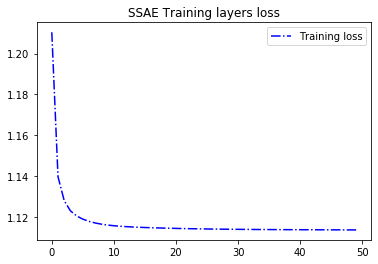

level: 1
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                544       
Total params: 1,072
Trainable params: 1,072
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
 - 0s - loss: 0.7448
Epoch 2/50
 - 0s - loss: 0.7182
Epoch 3/50
 - 0s - loss: 0.7161
Epoch 4/50
 - 0s - loss: 0.7151
Epoch 5/50
 - 0s - loss: 0.7145
Epoch 6/50
 - 0s - loss: 0.7141
Epoch 7/50
 - 0s - loss: 0.7139
Epoch 8/50
 - 0s - loss: 0.7137
Epoch 9/50
 - 0s - loss: 0.7136
Epoch 10/50
 - 0s - loss: 0.7134
Epoch 11/50
 - 0s - loss: 0.7133
Epoch 12/50
 - 0s - loss

<Figure size 432x288 with 0 Axes>

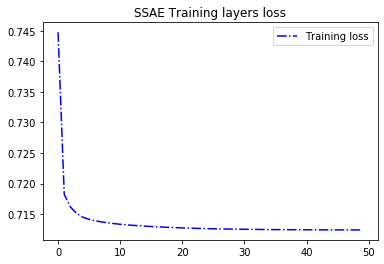

level: 2
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
Total params: 1,072
Trainable params: 1,072
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
 - 0s - loss: 0.7399
Epoch 2/50
 - 0s - loss: 0.7138
Epoch 3/50
 - 0s - loss: 0.7134
Epoch 4/50
 - 0s - loss: 0.7131
Epoch 5/50
 - 0s - loss: 0.7130
Epoch 6/50
 - 0s - loss: 0.7129
Epoch 7/50
 - 0s - loss: 0.7128
Epoch 8/50
 - 0s - loss: 0.7127
Epoch 9/50
 - 0s - loss: 0.7126
Epoch 10/50
 - 0s - loss: 0.7126
Epoch 11/50
 - 0s - loss: 0.7125
Epoch 12/50
 - 0s - loss

<Figure size 432x288 with 0 Axes>

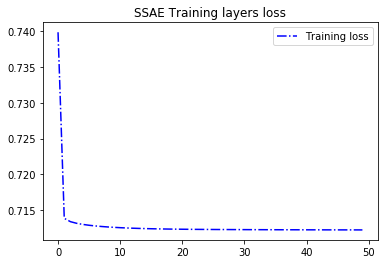

level: 3
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 43)                1419      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1408      
Total params: 2,827
Trainable params: 2,827
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
 - 0s - loss: 1.1215
Epoch 2/50
 - 0s - loss: 1.1134
Epoch 3/50
 - 0s - loss: 1.1130
Epoch 4/50
 - 0s - loss: 1.1127
Epoch 5/50
 - 0s - loss: 1.1124
Epoch 6/50
 - 0s - loss: 1.1123
Epoch 7/50
 - 0s - loss: 1.1121
Epoch 8/50
 - 0s - loss: 1.1120
Epoch 9/50
 - 0s - loss: 1.1120
Epoch 10/50
 - 0s - loss: 1.1119
Epoch 11/50
 - 0s - loss: 1.1119
Epoch 12/50
 - 0s - loss

<Figure size 432x288 with 0 Axes>

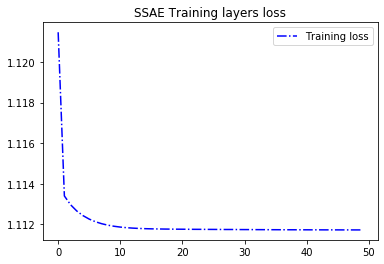

p_hat= Tensor("dense_3_1/activity_regularizer/Mean:0", shape=(16,), dtype=float32)
KLD= Tensor("dense_3_1/activity_regularizer/add:0", shape=(16,), dtype=float32)
p_hat= Tensor("dense_5_1/activity_regularizer/Mean:0", shape=(32,), dtype=float32)
KLD= Tensor("dense_5_1/activity_regularizer/add:0", shape=(32,), dtype=float32)
p_hat= Tensor("dense_7_1/activity_regularizer/Mean:0", shape=(43,), dtype=float32)
KLD= Tensor("dense_7_1/activity_regularizer/add:0", shape=(43,), dtype=float32)
Whole training:
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 43)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1408      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
________________

<Figure size 432x288 with 0 Axes>

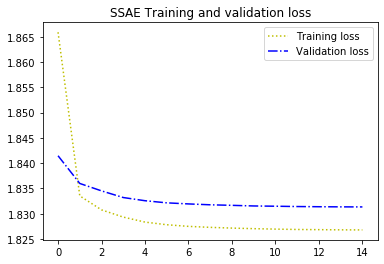

In [18]:
# 5层的stacked ae，实际上要使用4个ae，实例化4个ae
num_layers = 5
encoder_1 = AutoEncoderLayer(origin_dim, h_dim1)
encoder_2 = AutoEncoderLayer(h_dim1, h_dim2)
decoder_3 = AutoEncoderLayer(h_dim2, h_dim1)
decoder_4 = AutoEncoderLayer(h_dim1, origin_dim)
autoencoder_list = [encoder_1, encoder_2, decoder_3, decoder_4]

# 按照顺序对每一层进行预训练
print("Pre training:")
for level in range(num_layers - 1):
    print("level:", level)
    train_layers(encoder_list=autoencoder_list, layer=level, epochs=epochs_layer, batch_size=batch_size)


# 用训练好的4个ae构建stacked dae
stacked_ae = StackedAutoEncoder(autoencoder_list)
print("Whole training:")
# 进行全局训练优化
train_whole(sae=stacked_ae, epochs=epochs_whole, batch_size=batch_size)

In [19]:
##### 显示stacked dae重构后的效果 #####
X1_pre = stacked_ae.model.predict(X1)
X2_pre = stacked_ae.model.predict(X2)
X3_pre = stacked_ae.model.predict(X3)
X4_pre = stacked_ae.model.predict(X4)
print('X1: ',X1)
print('X1_pre: ',X1_pre)
print('X2: ',X2)
print('X2_pre: ',X2_pre)
print('X3: ',X3)
print('X3_pre: ',X3_pre)
print('X4: ',X2)
print('X4_pre: ',X4_pre)

X1:            L_T1      L_T2      L_T3      L_T4      L_T5      L_T6      L_T7  \
1170  0.488651  0.104012  0.765328  0.412776  0.353596  0.998148  0.445513   
579   0.637068  0.161366  0.928084  0.863257  0.248246  1.000000  0.942362   
2182  0.057699  0.743728  0.116650  0.597058  0.441985  1.000000  0.171913   
3608  0.732718  0.650633  0.390592  0.803850  0.849509  1.000000  0.663370   
2943  0.781443  0.942844  0.642789  0.411625  0.226870  0.191905  0.256424   
...        ...       ...       ...       ...       ...       ...       ...   
5734  0.663908  0.664919  0.067533  0.196580  0.586857  1.000000  0.517095   
5191  0.881324  0.625040  0.606332  0.622719  0.129357  0.345422  0.488734   
5390  0.904002  0.159823  0.587101  0.797103  0.615039  1.000000  0.488651   
860   0.279351  0.967521  0.414285  0.691745  0.573086  1.000000  0.846572   
7270  0.559075  0.660803  0.098045  0.392398  0.190758  1.000000  0.716468   

         F_PU1  S_PU1     F_PU2  ...    P_J300    P_J256  

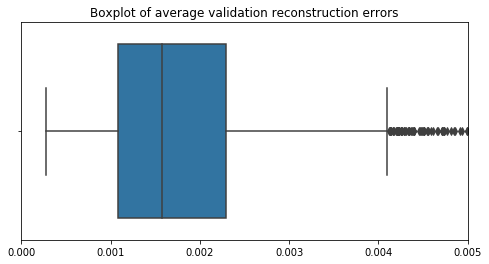

In [20]:
# perform detection

# get validation reconstruction errors
_, validation_errors = pred_error(X2_pre,X2)

# plot distribution of average validation reconstruction errors 
f, ax = plt.subplots(1, figsize = (8,4))
sns.boxplot(validation_errors.mean(axis=1), ax=ax)
ax.set_xlim([0,0.005])
ax.set_title('Boxplot of average validation reconstruction errors')

# set treshold as quantile of average reconstruction error
theta1 = validation_errors.mean(axis = 1).quantile(0.995)
theta2 = validation_errors.mean(axis = 1).quantile(0.992)

Yhat3, _ = detect(X3_pre,X3, theta = theta1 , window = 3, average=True)
Yhat4, _ = detect(X4_pre,X4, theta = theta2, window = 3, average=True)

In [21]:
results = pd.DataFrame(index = ['test dataset 01','test dataset 02'], 
                       columns = ['accuracy','f1_score','precision','recall','f2_score'])
results.loc['test dataset 01'] = compute_scores(Y3,Yhat3)
results.loc['test dataset 02'] = compute_scores(Y4,Yhat4)

print('Results:\n')
print(results)

Results:

                 accuracy  f1_score precision    recall  f2_score
test dataset 01  0.933445  0.623306  0.934959   0.46748  0.519422
test dataset 02  0.880326  0.580537  0.915344  0.425061  0.476059


[Text(0, 0, 'NO ATTACK'), Text(0, 0, 'ATTACK')]

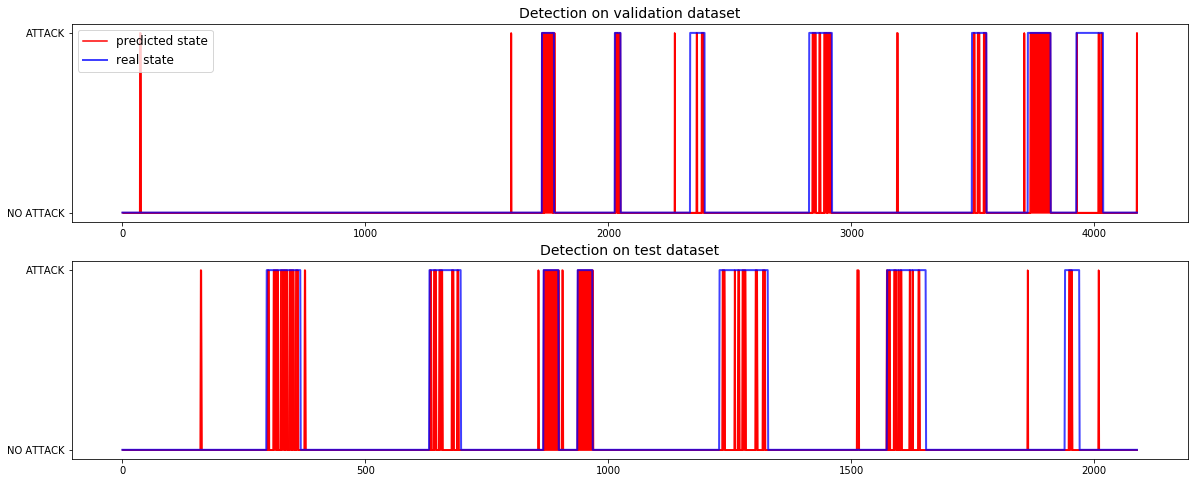

In [22]:
# plot figures
shade_of_gray = '0.75'
f, axes = plt.subplots(2,figsize = (20,8))
axes[0].plot(Yhat3, color = 'r', label = 'predicted state')
axes[0].fill_between(Yhat3.index, Yhat3.values, where=Yhat3.values <=1, interpolate=True, color='r')
axes[0].plot(Y3, color = 'b', alpha = 0.75, lw = 2, label = 'real state')
axes[0].set_title('Detection on validation dataset', fontsize = 14)
axes[0].set_yticks([0,1])
axes[0].set_yticklabels(['NO ATTACK','ATTACK'])
axes[0].legend(fontsize = 12, loc = 2)

axes[1].plot(Yhat4, color = 'r', label = 'predicted state')
axes[1].fill_between(Yhat4.index, Yhat4.values, where=Yhat4.values <=1, interpolate=True, color='r')
axes[1].plot(Y4, color = 'b', alpha = 0.75, lw = 2, label = 'real state')
axes[1].set_title('Detection on test dataset', fontsize = 14)
axes[1].set_yticks([0,1])
axes[1].set_yticklabels(['NO ATTACK','ATTACK'])

<Figure size 720x720 with 0 Axes>

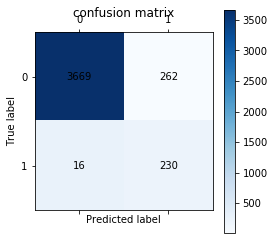

<Figure size 720x720 with 0 Axes>

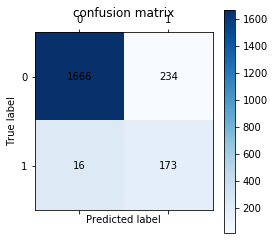

In [23]:
cm_plot(Y3,Yhat3)
cm_plot(Y4,Yhat4)